<a href="https://colab.research.google.com/github/paris3169/ZM-study-practice/blob/main/modular_NN_class13.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
class Layer():
    
    def __init__(self,inputs,outputs,act_type):
        self.inputs=inputs
        self.outputs=outputs
        self.activation_type=act_type
        self.W=None     #initialization of Weights and Bias for that layer
        self.B=None
        
    
    
    def getF_F_prime(self,Z):
        if self.activation_type==None:
            self.F=Z
            self.F_prime=Z/Z
        if self.activation_type=="sigma":
            self.F=1/(1+np.exp(-Z))
            self.F_prime=self.F*(1-self.F)
        elif self.activation_type=="ReLU":
            Z1=Z.flatten()
            self.F=np.array([max(x,0) for x in Z1]).reshape(-1,1)
            self.F_prime=np.array([max(x,0)/abs(x) for x in Z1]).reshape(-1,1)
        elif self.activation_type=="tanh":
            self.F=np.tanh(Z)
            self.F_prime=1-(self.F**2)
        elif self.activation_type=="Softmax":
            self.F=np.exp(Z)
            self.F=self.F/np.sum(self.F)
            self.F_prime=self.F*(1-self.F)
            
    
    def forward_propagation(self,X):
        Z=self.W.dot(X)+self.B    #X,Z and b are vectors while W is a Matrix
        self.getF_F_prime(Z)
        Y=self.F
        return Z,Y
        
    
    def backward_propagation(self,derE_dY,X):
        derE_dB=np.multiply(derE_dY,self.F_prime)
        derE_dW=derE_dB.dot(X.T)
        derE_dX=(self.W).T.dot(derE_dB)
        return derE_dB,derE_dW,derE_dX        
    

In [ ]:
#built the Neural Network Class

class Neural_Network:

    def __init__(self,X,descriptor,Loss="mse"):
        self.Net=[]
        #self.X=X
        #self.Y=None
        self.inputs=X.shape[0]
        self.N=X.shape[1]
        self.descriptor=descriptor
        self.Error=Loss
        self.builder()
        self.show()
        
    def builder(self):
        layer_inputs=self.inputs
        for layer in self.descriptor:
            layer_outputs=layer[0]
            layer_act_type=layer[1]
            self.Net.append(Layer(layer_inputs,layer_outputs,layer_act_type))
            layer_inputs=layer_outputs
        self.outputs=layer_outputs
    
    def get_Error(self,Y,Y_true):
        if self.Error=="mse":
            Error=0.5*np.mean((Y_true-Y)**2)
            dE_dY=(Y-Y_true)/len(Y)
            #print(dE_dY)
        elif self.Error=="cross_entropy":
            Error=-np.sum(Y_true*np.log(Y))

        return Error,dE_dY
    
    def calculate_rmse_mae(self,Y,Y_true):
        #this module is calculating the average rmse and mae across all samples
        N_samples=Y.shape[1]
        self.rmse=0
        self.mae=0
        for h in range(N_samples):
            self.rmse+=np.sqrt(self.get_Error(Y[:,h],Y_true[:,h])[0])
            self.mae+=np.mean(np.abs(Y[:,h]-Y_true[:,h]))
        self.rmse=self.rmse/N_samples
        self.mae=self.mae/N_samples
        
        return self.rmse, self.mae
        
        
    def show(self):
        print("input layer: ",self.inputs)
        print("output layer: ",self.outputs)
        print("data samples N: ",self.N)
        print("Error_type: ",self.Error)
        print("network descriptor: ",self.descriptor)
        layer_count=1
        for layer in self.Net:
            print("processing layer {}: ".format(layer_count),layer.__dict__)
            layer_count+=1
            
    def data_split(self,X,y,test_size=0.3,random_state=101):
        
        N_samples=X.shape[1]      #no of columns of inputs matrix
        n_test_samples=int(np.ceil(test_size*N_samples))

        c=[j for j in range(N_samples)]
        np.random.shuffle(c)    #shuffle the columns indexes

        #initialization of seed
        np.random.seed(random_state)
        #generation of random columns indexes
        c=np.array([np.random.randint(N_samples) for i in range(N_samples)])        
        
        X_shuffled=X[:,c]
        X_test=X_shuffled[:,:n_test_samples]
        X_train=X_shuffled[:,n_test_samples:]
        y_test=y[:,:n_test_samples]
        y_train=y[:,n_test_samples:]

        return X_train,X_test,y_train,y_test
    
    
    def fit(self,X_train,y_train,epochs=30,learning_rate=0.01):
        
        self.eta=learning_rate
        N_train_samples=X_train.shape[1]
        #initialization of weights and bias for each layer
        for layer in self.Net:
            layer.W=np.random.rand(layer.outputs,layer.inputs)  #W is the Weights matrix with shape (outputs,inputs)
            layer.B=np.random.rand(layer.outputs,1)             #B is the bias vector with shape (outputs,1)
        
        self.error_log=[]
        for k in range(epochs):
            #this is a loop across all N data samples provided as data inputs
            
            for h in range(N_train_samples):  
            
                #initialization of X-Train and y_train column vectors for forward propagation with shape (rows ,1)   
                Xh=X_train[:,h].reshape(X_train.shape[0],-1)  
                yh_train=y_train[:,h].reshape(y_train.shape[0],-1)
                
                #forward propagation loop 
                    
                for layer in self.Net:
                    Z,Y=layer.forward_propagation(Xh)
                    layer.Xh=Xh    #save the Xh inputs of current layer as this will be needed for backward propagation
                    Xh=Y           #input vector for next layer is the Y output of previous layer 
                
                #backward propagation loop
                
                Error,derE_dY=self.get_Error(Y,yh_train)   #initialization of Error and Error derivative wrt to Y
                print("Error: {} @ epoch k: {} and sample h: {} ".format(Error,k,h))
                for layer in reversed(self.Net):   
                    Xh=layer.Xh
                    derE_dB,derE_dW,derE_dX = layer.backward_propagation(derE_dY,Xh)
                
                    #update of W and B using Gradient Descent Batch formula (GDB)
                    layer.W-=self.eta*derE_dW
                    layer.B-=self.eta*derE_dB
                    
                    derE_dY=derE_dX  #the derivative of E wrt to Y at next layer is the derivative of E wrt to input at current layer
            
            
            self.error_log.append(Error)
        self.error_log=np.array(self.error_log)    
            
    def predict(self,X_test):        
        #this method is getting in input list of samples X_test and return Y as predicted outputs
        n=self.outputs
        N_test=X_test.shape[1]
        
        Y=np.zeros(shape=(n,N_test),dtype=float)
        for h in range(N_test):
            Xh=X_test[:,h].reshape(X_test.shape[0],-1)
            for layer in self.Net:
                Zh,Yh=layer.forward_propagation(Xh)
                Xh=Yh
            Y[:,h]=Yh.flatten()
        return Y 
    
    def classification_score(self,Y,y_test):
        #this is calculating the accuracy in case of classification
        
        # bit by bit metric calculation: is the predicted bit while b is the true bit
        def tp(a,b):  
            f=False
            if (a==1 and b==1): f=True
            return f

        def tn(a,b):  
            f=False
            if (a==0 and b==0): f=True
            return f

        def fp(a,b):  
            f=False
            if (a==1 and b==0): f=True
            return f

        def fn(a,b):  
            f=False
            if (a==0 and b==1): f=True
            return f

        def metrics(Y_hat,Y_true):      
            
            conf_matrix=np.zeros((2,2))
            TP=np.array([tp(a,b) for a,b in zip(Y_hat,Y_true)])
            TP=len(TP[TP==True])
            TN=np.array([tn(a,b) for a,b in zip(Y_hat,Y_true)])
            TN=len(TN[TN==True])
            FP=np.array([fp(a,b) for a,b in zip(Y_hat,Y_true)])
            FP=len(FP[FP==True])
            FN=np.array([fn(a,b) for a,b in zip(Y_hat,Y_true)])
            FN=len(FN[FN==True])

            conf_matrix[0,0]=TP
            conf_matrix[1,1]=TN
            conf_matrix[0,1]=FN
            conf_matrix[1,0]=FP
            print(conf_matrix)
            if TP!=0:
                accuracy=np.mean(Y_hat==Y_true)
                precision=TP/(TP+FP)
                recall=TP/(TP+FN)
                f1=2*(precision*recall)/(precision+recall)
                return accuracy,precision,recall,f1
            else:
                print("null")
                return np.nan, np.nan, np.nan, np.nan
        
        N_test=Y.shape[1]
        metric=[]
        no_outputs=Y.shape[0]
        Y_hat=np.zeros((no_outputs,N_test),dtype=int)

        for h in range(N_test):
            jmax=Y[:,h].argmax()
            Y_hat[jmax,h]=1   #   set as 1 the output class with highest probability

        for j in range(no_outputs):
            per_class_metric=metrics(Y_hat[j,:],y_test[j,:])
            metric.append(per_class_metric)
        metric=np.array(metric,dtype=float)
        df_score=pd.DataFrame(metric,columns=["acc","prec","rec","f1"])
        mean_values=df_score.mean(axis=0)

        return df_score, mean_values
        

proving my Neural Network on a real case

In [ ]:
from sklearn.datasets import load_iris

In [ ]:
iris=load_iris()

In [ ]:
iris.keys()

dict_keys(['data', 'target', 'target_names', 'DESCR', 'feature_names', 'filename'])

In [ ]:
y=iris.target.reshape(iris.target.shape[0],1)

In [ ]:
y.shape

(150, 1)

In [ ]:
X=iris.data

In [ ]:
X.shape

(150, 4)

In [ ]:
df=pd.DataFrame(iris.data,columns=iris.feature_names)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
dtypes: float64(4)
memory usage: 4.8 KB


In [ ]:
df['y']=iris.target

In [ ]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),y
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [ ]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

In [ ]:
df=pd.get_dummies(df,columns=["y"])

In [ ]:
df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),y_0,y_1,y_2
0,5.1,3.5,1.4,0.2,1,0,0
1,4.9,3.0,1.4,0.2,1,0,0
2,4.7,3.2,1.3,0.2,1,0,0
3,4.6,3.1,1.5,0.2,1,0,0
4,5.0,3.6,1.4,0.2,1,0,0


In [ ]:
X_T=df[['sepal length (cm)','sepal width (cm)','petal length (cm)','petal width (cm)']].values

In [ ]:
y_T=df[['y_0','y_1','y_2']].values

In [ ]:
X_T.shape

(150, 4)

In [ ]:
y_T[:5,:]

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0]], dtype=uint8)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X_T, y_T, test_size=0.30, random_state=101)

In [ ]:
X_train.shape

(105, 4)

In [ ]:
X_train=X_train.T
X_test=X_test.T

In [ ]:
X_test.shape

(4, 45)

In [ ]:
X_train.shape

(4, 105)

In [ ]:
y_train=y_train.T
y_test=y_test.T

In [ ]:
y_train.shape

(3, 105)

In [ ]:
y_test.shape

(3, 45)

In [ ]:
y_test[:,:10]

array([[1, 1, 1, 0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 1, 0, 1, 1, 0, 0],
       [0, 0, 0, 1, 0, 1, 0, 0, 1, 0]], dtype=uint8)

In [ ]:
descriptor=[[3,"Softmax"],[3,"Softmax"]]

In [ ]:
myNN=Neural_Network(X_train,descriptor)

input layer:  4
output layer:  3
data samples N:  105
Error_type:  mse
network descriptor:  [[3, 'Softmax'], [3, 'Softmax']]
processing layer 1:  {'inputs': 4, 'outputs': 3, 'activation_type': 'Softmax', 'W': None, 'B': None}
processing layer 2:  {'inputs': 3, 'outputs': 3, 'activation_type': 'Softmax', 'W': None, 'B': None}


In [ ]:
myNN.fit(X_train,y_train,epochs=50,learning_rate=0.05)

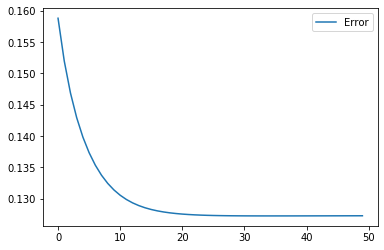

In [ ]:
df_error=pd.DataFrame(myNN.error_log,columns=["Error"])
df_error.plot()

In [ ]:
predict=myNN.predict(X_test)

In [ ]:
df_check=pd.concat([df_check,df1],axis=1)

In [ ]:
df_check.columns=["y1","y2","y3","y1*","y2*","y3*"]

In [ ]:
df_check

,y1,y2,y3,y1*,y2*,y3*
0,0.960556,0.039378,0.000065,1,0,0
1,0.947066,0.052806,0.000128,1,0,0
2,0.875923,0.122991,0.001085,1,0,0
3,0.005858,0.666570,0.327573,0,0,1
4,0.044797,0.857150,0.098053,0,1,0
5,0.011907,0.563749,0.424344,0,0,1
6,0.013033,0.721120,0.265847,0,1,0
7,0.033117,0.715624,0.251259,0,1,0
8,0.006677,0.486563,0.506759,0,0,1
9,0.825091,0.174084,0.000825,1,0,0


In [ ]:
myNN.classification_score(predict,y_test)

[[ 0. 13.]
 [ 0. 32.]]
null
[[ 0. 20.]
 [ 0. 25.]]
null
[[12.  0.]
 [33.  0.]]


(        acc      prec  rec        f1
 0       NaN       NaN  NaN       NaN
 1       NaN       NaN  NaN       NaN
 2  0.266667  0.266667  1.0  0.421053,
 acc     0.266667
 prec    0.266667
 rec     1.000000
 f1      0.421053
 dtype: float64)

In [ ]:
import os

In [ ]:
df=pd.read_csv(r"C:\Users\epardet\OneDrive - Ericsson AB\area lavoro\actual desktop\mytraining 2021\Python and data science\Udemy Courses\Python for Data Science\ANN supplementary materials\TensorFlow_FILES\DATA\kc_house_data.csv")

In [ ]:
len(df)

21597

In [ ]:
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [ ]:
df.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [ ]:
df1=df.drop(["id","price"],axis=1)

In [ ]:
df1.columns

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')

In [ ]:
df1["date_buy"]=pd.to_datetime(df1["date"])
df1["year_buy"]=df1["date_buy"].apply(lambda date:date.year)

In [ ]:
df1.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,...,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,date_buy,year_buy
0,10/13/2014,3,1.00,1180,5650,1.0,0,0,3,7,...,0,1955,0,98178,47.5112,-122.257,1340,5650,2014-10-13,2014
1,12/9/2014,3,2.25,2570,7242,2.0,0,0,3,7,...,400,1951,1991,98125,47.7210,-122.319,1690,7639,2014-12-09,2014
2,2/25/2015,2,1.00,770,10000,1.0,0,0,3,6,...,0,1933,0,98028,47.7379,-122.233,2720,8062,2015-02-25,2015
3,12/9/2014,4,3.00,1960,5000,1.0,0,0,5,7,...,910,1965,0,98136,47.5208,-122.393,1360,5000,2014-12-09,2014
4,2/18/2015,3,2.00,1680,8080,1.0,0,0,3,8,...,0,1987,0,98074,47.6168,-122.045,1800,7503,2015-02-18,2015


In [ ]:
df1.columns

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'date_buy', 'year_buy'],
      dtype='object')

In [ ]:
df1.drop(['zipcode'],axis=1,inplace=True)

In [ ]:
df1.drop(['date_buy'],axis=1,inplace=True)

In [ ]:
df1.drop(['date'],axis=1,inplace=True)

In [ ]:
df1.head()

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,lat,long,sqft_living15,sqft_lot15,year_buy
0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,47.5112,-122.257,1340,5650,2014
1,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,47.7210,-122.319,1690,7639,2014
2,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,47.7379,-122.233,2720,8062,2015
3,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,47.5208,-122.393,1360,5000,2014
4,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,47.6168,-122.045,1800,7503,2015


In [ ]:
y=df["price"].values

In [ ]:
df1.columns

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'year_buy'],
      dtype='object')

In [ ]:
X=df1.values

In [ ]:
X.shape

(21597, 18)

In [ ]:
y.shape

(100, 1)

In [ ]:
y=y.reshape(-1,1)

In [ ]:
y.shape

(100, 1)

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
X=X[:100,:]
y=y[:100,:]

In [ ]:
X.shape

(100, 18)

In [ ]:
y.shape

(100, 1)

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=101)

In [ ]:
scaler=MinMaxScaler()

In [ ]:
X_train=scaler.fit_transform(X_train)

In [ ]:
X_test=scaler.transform(X_test)

In [ ]:
X_train.shape

(70, 18)

In [ ]:
np.max(X_test)

1.3333333333333333

In [ ]:
from tensorflow.keras.models import Sequential

In [ ]:
from tensorflow.keras.layers import Dense

In [ ]:
model=Sequential()

In [ ]:
model.add(Dense(5,activation="sigmoid"))
#model.add(Dense(5,activation="relu"))
model.add(Dense(1))

In [ ]:
model.compile(optimizer="rmsprop",loss="mse")

In [ ]:
model.build(input_shape=X_train.shape)

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_22 (Dense)            (70, 5)                   95        
                                                                 
 dense_23 (Dense)            (70, 1)                   6         
                                                                 
Total params: 101
Trainable params: 101
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X_train,y_train,validation_data=(X_test,y_test),batch_size=128,epochs=100)

Epoch 1/100
1/1 [==============================] - 0s 73ms/step - loss: 342442344448.0000 - val_loss: 406190030848.0000
Epoch 2/100
1/1 [==============================] - 0s 31ms/step - loss: 342442344448.0000 - val_loss: 406190030848.0000
Epoch 3/100
1/1 [==============================] - 0s 28ms/step - loss: 342442344448.0000 - val_loss: 406189998080.0000
Epoch 4/100
1/1 [==============================] - 0s 33ms/step - loss: 342442377216.0000 - val_loss: 406189998080.0000
Epoch 5/100
1/1 [==============================] - 0s 36ms/step - loss: 342442344448.0000 - val_loss: 406189998080.0000
Epoch 6/100
1/1 [==============================] - 0s 31ms/step - loss: 342442344448.0000 - val_loss: 406189998080.0000
Epoch 7/100
1/1 [==============================] - 0s 28ms/step - loss: 342442377216.0000 - val_loss: 406189965312.0000
Epoch 8/100
1/1 [==============================] - 0s 32ms/step - loss: 342442311680.0000 - val_loss: 406189965312.0000
Epoch 9/100
1/1 [=======================

Epoch 69/100
1/1 [==============================] - 0s 25ms/step - loss: 342442049536.0000 - val_loss: 406189703168.0000
Epoch 70/100
1/1 [==============================] - 0s 29ms/step - loss: 342442082304.0000 - val_loss: 406189703168.0000
Epoch 71/100
1/1 [==============================] - 0s 23ms/step - loss: 342442082304.0000 - val_loss: 406189703168.0000
Epoch 72/100
1/1 [==============================] - 0s 22ms/step - loss: 342442049536.0000 - val_loss: 406189703168.0000
Epoch 73/100
1/1 [==============================] - 0s 25ms/step - loss: 342442049536.0000 - val_loss: 406189703168.0000
Epoch 74/100
1/1 [==============================] - 0s 25ms/step - loss: 342442016768.0000 - val_loss: 406189703168.0000
Epoch 75/100
1/1 [==============================] - 0s 24ms/step - loss: 342442016768.0000 - val_loss: 406189703168.0000
Epoch 76/100
1/1 [==============================] - 0s 25ms/step - loss: 342442049536.0000 - val_loss: 406189703168.0000
Epoch 77/100
1/1 [==============

In [ ]:
df=pd.DataFrame(model.history.history)

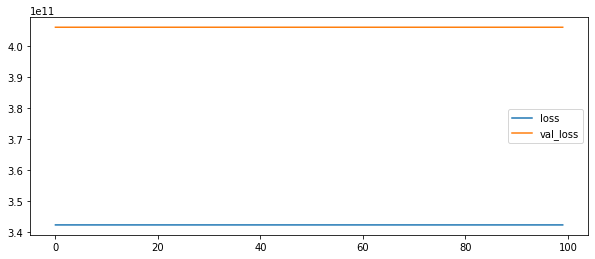

In [ ]:
df.plot(figsize=(10,4))

In [ ]:
y_hat=model.predict(X_test)

In [ ]:
from sklearn.metrics import mean_squared_error,mean_absolute_error,explained_variance_score

In [ ]:
mean_absolute_error(y_test,y_hat)

521231.4574777643

In [ ]:
np.sqrt(mean_squared_error(y_test,y_hat))

637330.0654389075

In [ ]:
explained_variance_score(y_test,y_hat)

3.63109469492251e-07

In [ ]:
single_house=df1.iloc[0].values

In [ ]:
single_house=single_house.reshape(1,-1)

In [ ]:
single_house.shape

(1, 18)

In [ ]:
model.predict(single_house)

array([[60716.723]], dtype=float32)

Trying my Neural network on this database

In [ ]:
X_train.shape

(70, 18)

In [ ]:
y_train.shape

(70, 1)

In [ ]:
np.max(y_train)

1350000.0

In [ ]:
X1_train=X_train.T
X1_test=X_test.T
y1_test=y_test.T
y1_train=y_train.T

In [ ]:
X1_train.shape

(18, 70)

In [ ]:
X1_test.shape

(18, 30)

In [ ]:
y1_train.shape

(1, 70)

In [ ]:
np.max(y1_test)

2000000.0

In [ ]:
y1_train=y1_train/np.max(y1_train)

In [ ]:
np.max(X_test)

1.3333333333333333

In [ ]:
y1_test=y1_test/np.max(y1_test)

In [ ]:
descriptor=[[10,"sigma"],[1,None]]

In [ ]:
myNN=Neural_Network(X1_train,descriptor)

input layer:  18
output layer:  1
data samples N:  70
Error_type:  mse
network descriptor:  [[10, 'sigma'], [1, None]]
processing layer 1:  {'inputs': 18, 'outputs': 10, 'activation_type': 'sigma', 'W': None, 'B': None}
processing layer 2:  {'inputs': 10, 'outputs': 1, 'activation_type': None, 'W': None, 'B': None}


In [ ]:
myNN.fit(X1_train,y1_train,epochs=100,learning_rate=0.02)

Error: 14.17891465693904 @ epoch k: 0 and sample h: 0 
Error: 8.392927552614816 @ epoch k: 0 and sample h: 1 
Error: 4.988954556503515 @ epoch k: 0 and sample h: 2 
Error: 2.69371386325666 @ epoch k: 0 and sample h: 3 
Error: 3.010933082732212 @ epoch k: 0 and sample h: 4 
Error: 1.879771113385283 @ epoch k: 0 and sample h: 5 
Error: 0.6667892285037527 @ epoch k: 0 and sample h: 6 
Error: 0.7337440050211017 @ epoch k: 0 and sample h: 7 
Error: 0.5698222241976453 @ epoch k: 0 and sample h: 8 
Error: 0.23321388127691986 @ epoch k: 0 and sample h: 9 
Error: 0.1096491290594698 @ epoch k: 0 and sample h: 10 
Error: 0.21821078217182158 @ epoch k: 0 and sample h: 11 
Error: 0.022818615745651347 @ epoch k: 0 and sample h: 12 
Error: 0.14161630032424594 @ epoch k: 0 and sample h: 13 
Error: 0.0189064354919693 @ epoch k: 0 and sample h: 14 
Error: 0.014113386382195406 @ epoch k: 0 and sample h: 15 
Error: 0.01764673411305406 @ epoch k: 0 and sample h: 16 
Error: 0.0698378704373751 @ epoch k: 0 a

Error: 0.0003412217485897558 @ epoch k: 10 and sample h: 65 
Error: 0.05502506565978107 @ epoch k: 10 and sample h: 66 
Error: 0.018359508829413333 @ epoch k: 10 and sample h: 67 
Error: 1.8358713953089156e-05 @ epoch k: 10 and sample h: 68 
Error: 0.025861749183964812 @ epoch k: 10 and sample h: 69 
Error: 0.02510143057441385 @ epoch k: 11 and sample h: 0 
Error: 0.00045180244068796004 @ epoch k: 11 and sample h: 1 
Error: 0.01574721205019387 @ epoch k: 11 and sample h: 2 
Error: 0.05576511185813002 @ epoch k: 11 and sample h: 3 
Error: 0.028731763065400616 @ epoch k: 11 and sample h: 4 
Error: 0.014769560274092092 @ epoch k: 11 and sample h: 5 
Error: 0.01807589271814222 @ epoch k: 11 and sample h: 6 
Error: 0.003966835330483955 @ epoch k: 11 and sample h: 7 
Error: 0.010156780655565294 @ epoch k: 11 and sample h: 8 
Error: 0.0022642318496033202 @ epoch k: 11 and sample h: 9 
Error: 0.008615408456732906 @ epoch k: 11 and sample h: 10 
Error: 0.01597826360091872 @ epoch k: 11 and samp

Error: 0.0007241628513410302 @ epoch k: 25 and sample h: 18 
Error: 0.010400591950024714 @ epoch k: 25 and sample h: 19 
Error: 0.026920217928853317 @ epoch k: 25 and sample h: 20 
Error: 0.0006432763479156263 @ epoch k: 25 and sample h: 21 
Error: 0.006909486041846223 @ epoch k: 25 and sample h: 22 
Error: 0.0007883129712942626 @ epoch k: 25 and sample h: 23 
Error: 0.023966554622471947 @ epoch k: 25 and sample h: 24 
Error: 0.06171189213249807 @ epoch k: 25 and sample h: 25 
Error: 0.025609023735308857 @ epoch k: 25 and sample h: 26 
Error: 0.020983589684049092 @ epoch k: 25 and sample h: 27 
Error: 0.043975692563273217 @ epoch k: 25 and sample h: 28 
Error: 0.0627558200664194 @ epoch k: 25 and sample h: 29 
Error: 0.028378508866290664 @ epoch k: 25 and sample h: 30 
Error: 0.01943889897216324 @ epoch k: 25 and sample h: 31 
Error: 0.004506476639619205 @ epoch k: 25 and sample h: 32 
Error: 0.010653771950900923 @ epoch k: 25 and sample h: 33 
Error: 0.01331898148900359 @ epoch k: 25 

Error: 0.015466439663566907 @ epoch k: 39 and sample h: 5 
Error: 0.020044645240652532 @ epoch k: 39 and sample h: 6 
Error: 0.003901510505937074 @ epoch k: 39 and sample h: 7 
Error: 0.010790859309700352 @ epoch k: 39 and sample h: 8 
Error: 0.0017583104274203998 @ epoch k: 39 and sample h: 9 
Error: 0.007224028943137164 @ epoch k: 39 and sample h: 10 
Error: 0.01718954419724581 @ epoch k: 39 and sample h: 11 
Error: 0.17055629234146433 @ epoch k: 39 and sample h: 12 
Error: 0.025789792786412177 @ epoch k: 39 and sample h: 13 
Error: 0.0006079974460111101 @ epoch k: 39 and sample h: 14 
Error: 0.0007273479084035736 @ epoch k: 39 and sample h: 15 
Error: 0.00042307061346380623 @ epoch k: 39 and sample h: 16 
Error: 0.03209681804454785 @ epoch k: 39 and sample h: 17 
Error: 0.0009565158356432274 @ epoch k: 39 and sample h: 18 
Error: 0.010096605453567054 @ epoch k: 39 and sample h: 19 
Error: 0.025088110851475845 @ epoch k: 39 and sample h: 20 
Error: 0.0003988825952598649 @ epoch k: 39

Error: 0.013010764364869074 @ epoch k: 57 and sample h: 52 
Error: 0.017795899286570546 @ epoch k: 57 and sample h: 53 
Error: 0.07559165287645817 @ epoch k: 57 and sample h: 54 
Error: 0.011748681101229029 @ epoch k: 57 and sample h: 55 
Error: 0.000225415340707618 @ epoch k: 57 and sample h: 56 
Error: 0.0344466373695257 @ epoch k: 57 and sample h: 57 
Error: 0.013172578335546692 @ epoch k: 57 and sample h: 58 
Error: 0.0008946444230627319 @ epoch k: 57 and sample h: 59 
Error: 0.00120271393489312 @ epoch k: 57 and sample h: 60 
Error: 0.00021460297148649744 @ epoch k: 57 and sample h: 61 
Error: 0.02034019803635443 @ epoch k: 57 and sample h: 62 
Error: 0.0170217719038472 @ epoch k: 57 and sample h: 63 
Error: 0.0038568252016775513 @ epoch k: 57 and sample h: 64 
Error: 0.00047530020330142247 @ epoch k: 57 and sample h: 65 
Error: 0.04715067101179687 @ epoch k: 57 and sample h: 66 
Error: 0.015603489896465105 @ epoch k: 57 and sample h: 67 
Error: 0.0005290239980425545 @ epoch k: 57

Error: 0.0038950122985881284 @ epoch k: 70 and sample h: 7 
Error: 0.011486117126866473 @ epoch k: 70 and sample h: 8 
Error: 0.0013251998934717074 @ epoch k: 70 and sample h: 9 
Error: 0.005841782148812753 @ epoch k: 70 and sample h: 10 
Error: 0.018401264625919712 @ epoch k: 70 and sample h: 11 
Error: 0.16379053833221513 @ epoch k: 70 and sample h: 12 
Error: 0.02442061226263709 @ epoch k: 70 and sample h: 13 
Error: 0.00022441334539971268 @ epoch k: 70 and sample h: 14 
Error: 0.0016101394531554882 @ epoch k: 70 and sample h: 15 
Error: 0.0003267856669331989 @ epoch k: 70 and sample h: 16 
Error: 0.03330339007609058 @ epoch k: 70 and sample h: 17 
Error: 0.001543855742386066 @ epoch k: 70 and sample h: 18 
Error: 0.009321351096214755 @ epoch k: 70 and sample h: 19 
Error: 0.021490081950787537 @ epoch k: 70 and sample h: 20 
Error: 8.992572362794763e-05 @ epoch k: 70 and sample h: 21 
Error: 0.006529697076318231 @ epoch k: 70 and sample h: 22 
Error: 0.00010378068062031431 @ epoch k

Error: 0.005771023272846164 @ epoch k: 84 and sample h: 45 
Error: 0.0002508546679604608 @ epoch k: 84 and sample h: 46 
Error: 0.005082128552916336 @ epoch k: 84 and sample h: 47 
Error: 0.001849125920039917 @ epoch k: 84 and sample h: 48 
Error: 0.011660088157312357 @ epoch k: 84 and sample h: 49 
Error: 0.013214048902264177 @ epoch k: 84 and sample h: 50 
Error: 0.18243129801178742 @ epoch k: 84 and sample h: 51 
Error: 0.01502047055164088 @ epoch k: 84 and sample h: 52 
Error: 0.01718040372451541 @ epoch k: 84 and sample h: 53 
Error: 0.06774189304271765 @ epoch k: 84 and sample h: 54 
Error: 0.01012641446037072 @ epoch k: 84 and sample h: 55 
Error: 0.0002649640268056314 @ epoch k: 84 and sample h: 56 
Error: 0.031629490270849804 @ epoch k: 84 and sample h: 57 
Error: 0.015219146018023834 @ epoch k: 84 and sample h: 58 
Error: 0.0008724787786234525 @ epoch k: 84 and sample h: 59 
Error: 0.0009471365233657002 @ epoch k: 84 and sample h: 60 
Error: 0.0009493130161657604 @ epoch k: 8

Error: 0.014163090824873692 @ epoch k: 99 and sample h: 33 
Error: 0.014759876342941831 @ epoch k: 99 and sample h: 34 
Error: 0.008760429439301068 @ epoch k: 99 and sample h: 35 
Error: 0.0044193681999032805 @ epoch k: 99 and sample h: 36 
Error: 0.010097058298735567 @ epoch k: 99 and sample h: 37 
Error: 0.0019665410543585416 @ epoch k: 99 and sample h: 38 
Error: 0.006342299346216172 @ epoch k: 99 and sample h: 39 
Error: 0.001032045394241401 @ epoch k: 99 and sample h: 40 
Error: 0.0025092605130814264 @ epoch k: 99 and sample h: 41 
Error: 0.0007766060791660073 @ epoch k: 99 and sample h: 42 
Error: 0.0034895593574331466 @ epoch k: 99 and sample h: 43 
Error: 0.007168256994845742 @ epoch k: 99 and sample h: 44 
Error: 0.005180569423507652 @ epoch k: 99 and sample h: 45 
Error: 0.00012153984504067986 @ epoch k: 99 and sample h: 46 
Error: 0.005366523013109552 @ epoch k: 99 and sample h: 47 
Error: 0.0023355916703960136 @ epoch k: 99 and sample h: 48 
Error: 0.010370336320784053 @ ep

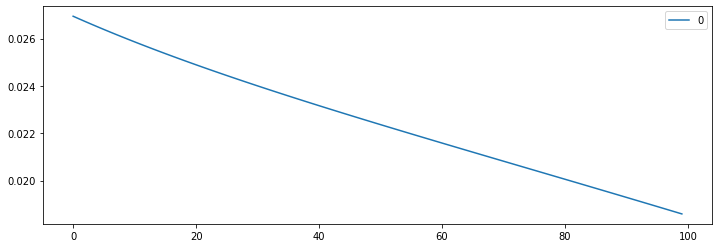

In [ ]:
df_error=pd.DataFrame(myNN.error_log)
df_error.plot(figsize=(12,4))

In [ ]:
predict=myNN.predict(X1_test)

In [ ]:
myNN.calculate_rmse_mae(predict,y1_test)

(0.15895304355998982, 0.3648475250095062)

In [ ]:
X1_test.shape

(18, 30)

In [ ]:
y1_test.shape

(1, 30)

In [ ]:
df2=pd.DataFrame(predict.T)

In [ ]:
df2["True"]=y1_test.T

In [ ]:
df2.columns=["predict","y True"]

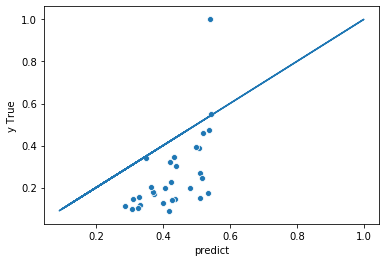

In [ ]:
sns.scatterplot(x="predict",y="y True",data=df2)
plt.plot(y1_test.T,y1_test.T)

In [ ]:
y_test.shape

(30, 1)

In [ ]:
y.shape

(100, 1)

In [ ]:
df3=pd.DataFrame(y,columns=["y"])

In [ ]:
y_true=y_test[:10]
y_z=predict[:10]

In [ ]:
-np.sum(y_true*np.log(y_z))

151074240.0334109

In [ ]:
df3.sort_values(by="y",ascending=False).head(20)

,y
21,2000000.0
49,1350000.0
69,1330000.0
5,1230000.0
91,1100000.0
70,1040000.0
66,975000.0
58,951000.0
85,940000.0
26,937000.0


In [ ]:
def converter(n):
    return np.array([int(char) for char in bin(n)[2:]])

In [ ]:
converter(10)

array([1, 0, 1, 0])

In [ ]:
bin(2)

'0b10'

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
hotencoder=OneHotEncoder()

In [ ]:
Y=[[1,2,3]]
Y_encoded=hotencoder

In [ ]:
hotencoder.fit(Y)

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='error', sparse=True)

In [ ]:
Y_encoded=hotencoder.transform(Y)

<1x3 sparse matrix of type '<class 'numpy.float64'>'
	with 3 stored elements in Compressed Sparse Row format>